## RAGAS 기본 데이터의 한계와 Custom 데이터의 필요성
1. Custom Dataset의 특징 및 구성
    - 사용자 페르소나와 핵심 키워드를 기반으로 실제 사용자 질의와 유사한 형태의 데이터셋을 구축
    - 실제 사용자 시나리오를 반영한 평가 데이터셋으로 구성

2. First-Stage Retrieve 단계에서의 실험 결과
    - Custom Dataset과 RAGAS 합성 데이터셋을 비교 실험 수행
    - Custom Dataset이 RAGAS 합성 데이터셋 대비 더 도전적인 평가 문제를 제시함을 통계적으로 확인
    - 상위 10% 결과 비교 분석 결과, 두 데이터셋 간 공통 포함 비율이 14%에 불과
    - 이는 두 데이터셋이 서로 다른 랭킹 기준을 가지고 있음을 시사

3. 결론
    - Custom Dataset과 RAGAS 합성 데이터셋의 조합이 First-Stage Retrieve 단계의 평가에 필수적
    - Custom Dataset은 실제 사용자 시나리오를 반영한 현실적인 평가 기준을 제공
    - RAGAS 합성 데이터셋은 일반적인 케이스에 대한 평가 기준을 제공
    - 두 데이터셋의 조합을 통해 더 포괄적이고 견고한 평가 체계 구축 가능

## RAGAS Customization 필요성 확인 절차
1. ragas 기반의 기본 합성 데이터셋 생성
2. custom 데이터셋 생성
3. 기본 합성 데이터셋 기반 검색 절차의 optimization 진행
4. custom 데이터셋 기반 검색 절차의 optimization 진행
5. 평가지표 비교를 통한 필요성 확인
   * 통계적 유의성 테스트
   * 정렬 결과 차이 분석(Rank Sensitivity)

In [1]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from dotenv import load_dotenv
load_dotenv()

from ragas.testset.graph import KnowledgeGraph

c:\Users\owner\anaconda3\envs\SportAgent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kg = KnowledgeGraph.load('../data/rag/kg.json')

In [3]:
origin_path = '../data/rag/valid_dataset.csv'
origin_dataset = pd.read_csv(origin_path)

origin_dataset['reference_contexts'] = origin_dataset['reference_contexts'].apply(lambda x : eval(x))

In [4]:
print(len(origin_dataset))
origin_dataset.head(2)

56


,user_input,reference_contexts,reference,synthesizer_name,reference_contexts_section
0,바벨 잡는 방법과 앉아받기 동작의 올바른 수행을 결합하여 최적의 리프팅 기술을 설명해줘.,"[바벨을 잡는 방법에는 크게 오버그립(over grip), 언더그립(under gr...","바벨 잡는 방법에는 오버그립, 언더그립, 리버스그립, 훅그립이 있으며, 각각의 그립...",multi_hop_abstract_query_synthesizer,"['Ⅲ. 역도경기 기술의 구조와 훈련법', 'Ⅲ. 역도경기 기술의 구조와 훈련법']"
1,"스포츠 심리학자들은 선수의 성과 향상에 어떤 역할을 하며, 그들의 개인 문제에 대한...",[성공적인 상\n담 진행을 위해서 상담사는 내담자의 감정에 공감할 수 있어야 한다....,스포츠 심리학자들은 운동선수의 성과를 향상시키기 위해 여러 가지 역할을 수행합니다....,multi_hop_abstract_query_synthesizer,"['II. 역도의 스포츠 과학적 원리', 'II. 역도의 스포츠 과학적 원리']"


In [5]:
import json
from langchain_core.documents import Document

documents = [Document(page_content=node.properties['page_content'],
                      metadata=node.properties['document_metadata'])
                       for node in kg.nodes]

# Retrieve(First-Stage Retrieval) 최적화

### Dense Retriever 선언

In [6]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(documents, embeddings)

### Sparse Retriever 선언

In [7]:
from kiwipiepy import Kiwi
from typing import List, Dict, Any
from rank_bm25 import BM25Okapi

class BM25:
    def __init__(self, type: str = 'None', k: int = 20):
        self.k = k
        self.type = type
        self.kiwi = Kiwi()
        self.texts = []
        self.vectorizer = None

    
    def tokenize(self, text: str) -> List[str]:
        if self.type == 'None':
            return text.split()
        elif self.type == 'kiwi':
            return [token.form for token in self.kiwi.tokenize(text)]
        elif self.type == 'kiwi_pos':
            return [token.form for token in self.kiwi.tokenize(text) if token.tag.startswith(('NN', 'VV', 'VA'))]
        else:
            raise ValueError(f"지원하지 않는 토크나이저 타입입니다: {self.type}. 'None', 'kiwi', 'kiwi_pos' 중 하나를 선택해주세요.")
        

    def from_texts(self, texts: List[str]):
        self.texts = texts
        texts_processed = [self.tokenize(t) for t in texts]
        self.vectorizer = BM25Okapi(texts_processed)
    
    def search(self, query: str) -> List[str]:
        if not self.vectorizer:
            raise ValueError("BM25가 초기화되지 않았습니다. from_texts()를 먼저 호출하세요.")
        
        processed_query = self.tokenize(query)
        
        return self.vectorizer.get_top_n(processed_query, self.texts, n=self.k)

In [8]:
kiwi_pos = BM25(k=20, type='kiwi_pos')
kiwi = BM25(k=20, type='kiwi')
bm25 = BM25(k=20)

texts = [node.properties['page_content'] for node in kg.nodes]
kiwi_pos.from_texts(texts)
kiwi.from_texts(texts)
bm25.from_texts(texts)

## 1. Precompute Retrievals
- Retrieve 최적화 과정 중, search의 중복을 최소화를 통해 절차 효율화
- dense retrieve: 최다 검색 조건(fetch_k: 2.5, k:15) 기준, 사용자 쿼리(user_input)별 Retrieve 수행
- sparse retrieve: 최다 검색 조건(k: 20) 기준 및 sparse retriever 조합(bm25, bm25 + kiwi, bm25 + kiwi_pos)에 대한 사용자 쿼리(user_input)별 Retrieve 수행

In [9]:
import itertools

def precompute_retrievals(df, db, bm25, kiwi, kiwi_pos, 
                          k_list=[10, 15, 20], 
                          fetch_k_list=[1.5, 2.0], 
                          lambda_mult_list=[0.3, 0.5, 0.7]):
    df['precompute_dense'] = df['user_input'].apply(lambda x : db.similarity_search_with_score(x, k=int(20)))
    df['precompute_sparse_bm25'] = df['user_input'].apply(lambda x : bm25.search(x))
    df['precompute_sparse_bm25_kiwi'] = df['user_input'].apply(lambda x : kiwi.search(x))
    df['precompute_sparse_bm25_kiwi_pos'] = df['user_input'].apply(lambda x : kiwi_pos.search(x))

    combinations = list(itertools.product(k_list, fetch_k_list, lambda_mult_list))
    for (k, fetch_k, lambda_mult) in tqdm(combinations):
        column_name = f'mmr_k{k}_fetch{fetch_k}_lambda{lambda_mult}'
        
        df[column_name] = df['user_input'].apply(
            lambda x: db.similarity_search_with_score(
                x, 
                k=k, 
                fetch_k=int(k*fetch_k),
                search_type='mmr', 
                lambda_mult=lambda_mult
            )
        )
    
    return df

In [10]:
origin_dataset = precompute_retrievals(origin_dataset, db, bm25, kiwi, kiwi_pos)
origin_dataset.to_csv('../data/rag/precompute_validset.csv', index = False)

100%|██████████| 18/18 [09:36<00:00, 32.04s/it]


## 2. Retrieve Parameter 조합 생성
### 2-1. 공통 파라미터
* k: [10, 15, 20]
* alpha: [0, 20, 40, 60, 80, 100]

### 2-2. Dense Retriever
1. 기본 설정
    * Embedding Model: OpenAIEmbeddings
    * VectorStore: Faiss
2. Dense Type 분류
    * MRR 방식
        * fetch_k: [1.5, 2]
        * lambda_mult: [0.3, 0.5, 0.7]
    * Threshold 방식
        * score_threshold: [0.1, 0.2, 0,3, 0.4, 0.5]


### 2-3. Sparse Retriever
* 형태소 분석기 유무 기준
    * bm25
    * bm25 + kiwi
    * bm25 + kiwi_pos: 명사, 동사, 형용사

In [11]:
from itertools import product

def generate_sparse_configs(k_values, analyzers):
    """Sparse Retriever 설정 생성 (alpha = 0)"""
    return [
        {
            "k": k,
            "alpha": 0,
            "morphological_analyzer": analyzer
        }
        for k, analyzer in product(k_values, analyzers)
    ]

def generate_dense_configs(k_values, mrr_params, threshold_params):
    """Dense Retriever 설정 생성 (alpha = 100)"""
    configs = []
    
    # MRR 조합
    for k in k_values:
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "mmr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                }
            })
    
    # Threshold 조합
    for k in k_values:
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                }
            })
    
    return configs

def generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params):
    """Hybrid Retriever 설정 생성 (0 < alpha < 100)"""
    configs = []
    
    for k, alpha, analyzer in product(k_values, hybrid_alphas, analyzers):
        # MRR 조합
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "mmr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                },
                "morphological_analyzer": analyzer
            })
        
        # Threshold 조합
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                },
                "morphological_analyzer": analyzer
            })
    
    return configs

def generate_retriever_configs(
        k_values=[10, 15, 20],
        analyzers=["bm25", "bm25_kiwi", "bm25_kiwi_pos"],
        hybrid_alphas = [20, 40, 60, 80],
        fetch_k=[1.5, 2],
        lambda_mult=[0.3, 0.5, 0.7],
        score_threshold=[0.1, 0.2, 0.3, 0.4, 0.5]
    ):   
    # Dense Retriever 파라미터
    mrr_params = {
        "fetch_k": fetch_k,
        "lambda_mult": lambda_mult
    }
    threshold_params = {
        "score_threshold": score_threshold
    }
    
    # 각 타입별 설정 생성
    sparse_configs = generate_sparse_configs(k_values, analyzers)
    dense_configs = generate_dense_configs(k_values, mrr_params, threshold_params)
    hybrid_configs = generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params)
    
    # 모든 설정 합치기
    return sparse_configs + dense_configs + hybrid_configs

In [12]:
configs = generate_retriever_configs()

## 3. 성능 평가
* 평가지표는 Recall, MAP, NDCG를 사용
* first stage retriever 후의 Rerank 단계를 고려해, 지표 중요도 순서를 Recall, MAP, NDCG로 설정

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_ndcg(predictions, ground_truth, k):
    """
    NDCG@k 직접 구현0
    """
    def dcg_at_k(relevance_scores, k):
        dcg = 0.0
        for i in range(min(len(relevance_scores), k)):
            dcg += relevance_scores[i] / np.log2(i + 2)
        return dcg
    
    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    relevance = [1 if doc in truth_contents else 0 for doc in pred_contents]
    
    ideal_ranking = [1] * min(len(truth_contents), k) + [0] * (k - len(truth_contents))
    dcg = dcg_at_k(relevance, k)
    idcg = dcg_at_k(ideal_ranking, k)
    ndcg = dcg / idcg if idcg > 0 else 0.0
    
    return ndcg

def calculate_recall(predictions, ground_truth, k):
    """
    Recall@k 계산
    """

    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    pred_set = set(pred_contents)
    truth_set = set(truth_contents)
    relevant_retrieved = len(pred_set & truth_set)
    return relevant_retrieved / len(truth_set) if truth_set else 0.0

def calculate_map(predictions, ground_truth, k):
    """
    MAP@k 계산
    """
    if not ground_truth:
        return 0.0

    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    # 각 위치에서의 precision 계산
    precisions = []
    relevant_count = 0
    
    for i, doc in enumerate(pred_contents):
        if doc in truth_contents:
            relevant_count += 1
            precisions.append(relevant_count / (i + 1))
    
    return np.mean(precisions) if precisions else 0.0


def evaluate_metrics(predictions, ground_truth, k):
    """
    NDCG, Recall, MAP 평가 수행
    predictions와 ground_truth는 각각 리스트의 리스트 형태
    """
    ndcg_scores = []
    recall_scores = []
    map_scores = []
    
    # 각 쿼리별로 평가 수행
    for pred, truth in zip(predictions, ground_truth):
        ndcg_scores.append(calculate_ndcg(pred, truth, k))
        recall_scores.append(calculate_recall(pred, truth, k))
        map_scores.append(calculate_map(pred, truth, k))
    
    # 평균 점수 계산
    return {
        'ndcg': np.mean(ndcg_scores),
        'recall': np.mean(recall_scores),
        'map': np.mean(map_scores)
    }


def combine_hybrid_results(dense_results, sparse_results, alpha, k):
    """
    Dense와 Sparse Retriever의 결과를 결합
    
    Parameters:
    -----------
    dense_results : list of lists
        Dense Retriever의 결과 리스트
    sparse_results : list of lists
        Sparse Retriever의 결과 리스트
    alpha : float
        Dense Retriever의 가중치 (0~100)
    k : int
        반환할 문서 수
    
    Returns:
    --------
    list of lists
        결합된 결과 리스트
    """
    combined_results = []
    
    # 각 쿼리별로 결과 결합
    for dense_pred, sparse_pred in zip(dense_results, sparse_results):
        # 문서와 점수 매핑 생성
        doc_scores = {}
        
        # Dense 결과 처리
        for i, doc in enumerate(dense_pred):
            # 순위 기반 점수 계산 (높은 순위일수록 높은 점수)
            rank_score = 1.0 / (i + 1)
            # alpha를 0~1 범위로 정규화
            normalized_alpha = alpha / 100.0
            doc_scores[doc] = normalized_alpha * rank_score
        
        # Sparse 결과 처리
        for i, doc in enumerate(sparse_pred):
            rank_score = 1.0 / (i + 1)
            # (1 - alpha)를 sparse의 가중치로 사용
            normalized_alpha = alpha / 100.0
            if doc in doc_scores:
                doc_scores[doc] += (1 - normalized_alpha) * rank_score
            else:
                doc_scores[doc] = (1 - normalized_alpha) * rank_score
        
        # 최종 점수로 정렬하여 상위 k개 선택
        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        combined_results.append([doc for doc, _ in sorted_docs[:k]])
    
    return combined_results

def extract_text_from_docs(doc_score_list):
    return [pred.page_content for prediction in doc_score_list for pred, _ in prediction]

def optimization(configs, precompute_df):
    results = []
    
    for config in tqdm(configs):
        if config['alpha'] == 0:  # Sparse Retriever
            if config['morphological_analyzer'] == 'bm25':
                predictions = precompute_df['precompute_sparse_bm25']
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                predictions = precompute_df['precompute_sparse_bm25_kiwi']
            else:  # bm25_kiwi_pos
                predictions = precompute_df['precompute_sparse_bm25_kiwi_pos']
                
        elif config['alpha'] == 100:  # Dense Retriever
            if config['dense_type'] == 'mmr':
                # 미리 계산된 MMR 결과 사용
                column_name = f'mmr_k{config["k"]}_fetch{config["dense_params"]["fetch_k"]:.1f}_lambda{config["dense_params"]["lambda_mult"]}'
                predictions = precompute_df[column_name].to_list()
                predictions = extract_text_from_docs(predictions)


            else:  # threshold
                # Threshold 파라미터 적용
                score_threshold = config['dense_params']['score_threshold']
                predictions = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold][:config['k']]
                )
            
        else:  # Hybrid Retriever
            # dense 결과 처리
            if config['dense_type'] == 'mmr':
                # 미리 계산된 MMR 결과 사용
                column_name = f'mmr_k{config["k"]}_fetch{config["dense_params"]["fetch_k"]:.1f}_lambda{config["dense_params"]["lambda_mult"]}'
                dense_results = precompute_df[column_name].to_list()
                dense_results = extract_text_from_docs(dense_results)

            else:  # threshold
                score_threshold = config['dense_params']['score_threshold']
                dense_results = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold]
                )
            
            # sparse 결과 처리
            if config['morphological_analyzer'] == 'bm25':
                sparse_results = precompute_df['precompute_sparse_bm25']
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi']
            else:  # bm25_kiwi_pos
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi_pos']
            
            # hybrid scoring 및 ranking
            predictions = combine_hybrid_results(
                dense_results, 
                sparse_results, 
                config['alpha'],
                config['k']
            )


        # 평가 수행
        scores = evaluate_metrics(predictions, precompute_df['reference_contexts'], config['k'])
        
        group_metrics = {}
        precompute_df = precompute_df.reset_index(drop=True)  # 인덱스 정렬
        for name, group in precompute_df.groupby('synthesizer_name'):
            indices = group.index.tolist()
            pred_group = [predictions[i] for i in indices]
            truth_group = group['reference_contexts'].tolist()

            # g_scores = evaluate_metrics(pred_group, truth_group, config['k'])

            # 컬럼별 저장
            group_metrics[f'recall_{name}'] =  np.mean([calculate_recall(pred, truth, config['k']) for pred, truth in zip(pred_group, truth_group)])
            # group_metrics[f'recall_{name}'] = g_scores['recall']
            # group_metrics[f'map_{name}'] = g_scores['map']

        # 결과 저장
        result = {
            'k': config['k'],
            'alpha': config['alpha'],
            'dense_type': config.get('dense_type', None),
            'morphological_analyzer': config.get('morphological_analyzer', None),
            'fetch_k': config.get('dense_params', {}).get('fetch_k'),
            'lambda_mult': config.get('dense_params', {}).get('lambda_mult'),
            'score_threshold': config.get('dense_params', {}).get('score_threshold'),
            'ndcg': scores['ndcg'],
            'recall': scores['recall'],
            'map': scores['map']
        }
        result.update(group_metrics)  # synthesizer 별 점수 추가
        results.append(result)
    
    return pd.DataFrame(results)

In [14]:
custom_dataset = origin_dataset[(origin_dataset['synthesizer_name'].str.contains('exercise')) | (origin_dataset['synthesizer_name'].str.contains('body'))]
origin_dataset = origin_dataset.drop(custom_dataset.index)
custom_dataset = custom_dataset.reset_index(drop=True)

In [15]:
optimization_result = optimization(configs, origin_dataset)
optimization_result_custom = optimization(configs, custom_dataset)
optimization_result_custom = optimization_result_custom.rename(columns = {column: 'custom_' + column for column in optimization_result_custom.columns[7:]})
optimization_result = optimization_result.iloc[:, :10]
optimization_result_custom = optimization_result_custom.iloc[:, :10]
optimization_result = optimization_result.merge(optimization_result_custom, on=list(optimization_result_custom.columns[:-3]), how='left')

100%|██████████| 438/438 [00:01<00:00, 273.44it/s]


In [16]:
optimization_result.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,custom_ndcg,custom_recall,custom_map
367,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.657230,0.916667,0.558419,0.505880,0.714286,0.497066
334,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.636789,0.916667,0.551902,0.474805,0.678571,0.457604
235,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.652075,0.898810,0.558667,0.479305,0.625000,0.523256
368,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.638534,0.898810,0.539478,0.492737,0.714286,0.483044
400,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.637077,0.898810,0.532034,0.515656,0.696429,0.501681
202,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.626074,0.880952,0.553391,0.464671,0.642857,0.457416
268,15,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.631720,0.880952,0.547659,0.489921,0.607143,0.548935
335,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.617960,0.880952,0.537078,0.474834,0.678571,0.457651
401,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.598517,0.880952,0.491087,0.482380,0.696429,0.453865
357,20,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.628301,0.863095,0.576854,0.475653,0.696429,0.450246


In [17]:
optimization_result.sort_values(by=['custom_recall', 'custom_map', 'custom_ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,custom_ndcg,custom_recall,custom_map
367,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.657230,0.916667,0.558419,0.505880,0.714286,0.497066
368,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.638534,0.898810,0.539478,0.492737,0.714286,0.483044
400,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.637077,0.898810,0.532034,0.515656,0.696429,0.501681
356,20,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.641546,0.845238,0.596507,0.492116,0.696429,0.474102
422,20,80,threshold,bm25_kiwi,NaN,NaN,0.1,0.606268,0.815476,0.582156,0.497406,0.696429,0.457626
401,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.598517,0.880952,0.491087,0.482380,0.696429,0.453865
357,20,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.628301,0.863095,0.576854,0.475653,0.696429,0.450246
323,20,20,threshold,bm25_kiwi,NaN,NaN,0.1,0.615130,0.809524,0.566879,0.474952,0.696429,0.443152
324,20,20,threshold,bm25_kiwi,NaN,NaN,0.2,0.608642,0.809524,0.560828,0.466603,0.696429,0.431585
389,20,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.615422,0.845238,0.570518,0.505912,0.678571,0.492347


In [18]:
tmp = optimization_result.loc[optimization_result['k'] == 10]

In [22]:
tmp.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,custom_ndcg,custom_recall,custom_map
103,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.623298,0.809524,0.568878,0.461971,0.571429,0.519345
59,10,20,threshold,bm25_kiwi,NaN,NaN,0.1,0.604370,0.773810,0.583773,0.426031,0.535714,0.465774
70,10,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.592039,0.773810,0.543665,0.423431,0.517857,0.487684
60,10,20,threshold,bm25_kiwi,NaN,NaN,0.2,0.590347,0.755952,0.578118,0.412243,0.517857,0.469742
136,10,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.586369,0.738095,0.597080,0.478564,0.571429,0.561494
104,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.584271,0.738095,0.557370,0.448544,0.571429,0.505060
71,10,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.573210,0.738095,0.528841,0.423431,0.517857,0.487684
81,10,40,threshold,bm25,NaN,NaN,0.1,0.500560,0.732143,0.452353,0.377520,0.500000,0.427126
27,10,100,threshold,None,NaN,NaN,0.1,0.557178,0.714286,0.574589,0.427776,0.500000,0.538988
114,10,60,threshold,bm25,NaN,NaN,0.1,0.518831,0.714286,0.509524,0.433438,0.517857,0.535658


In [21]:
tmp.sort_values(by=['custom_recall', 'custom_map', 'custom_ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,custom_ndcg,custom_recall,custom_map
125,10,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.564178,0.690476,0.596811,0.484262,0.607143,0.521797
92,10,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.593582,0.702381,0.613733,0.459018,0.589286,0.480244
136,10,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.586369,0.738095,0.597080,0.478564,0.571429,0.561494
158,10,80,threshold,bm25_kiwi,NaN,NaN,0.1,0.569561,0.708333,0.589172,0.459682,0.571429,0.532922
103,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.623298,0.809524,0.568878,0.461971,0.571429,0.519345
104,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.584271,0.738095,0.557370,0.448544,0.571429,0.505060
137,10,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.533644,0.684524,0.542659,0.445435,0.571429,0.490065
93,10,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.574457,0.702381,0.584368,0.437715,0.571429,0.472654
126,10,60,threshold,bm25_kiwi,NaN,NaN,0.2,0.531349,0.672619,0.556888,0.432122,0.571429,0.467829
169,10,80,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.563065,0.690476,0.595238,0.452476,0.553571,0.545181


## 4. Custom Dataset의 필요성 검증
1. 하위 이상치 조합 제거
    * 극단적으로 낮은 성능을 보이는 조합을 제거하여 분석의 신뢰도를 확보함.
2. 원본 vs 커스텀 데이터셋 간 평가지표 차이 검정
    * 두 평가지표 간 통계적으로 유의미한 차이가 존재함을 확인.
    * 커스텀 데이터셋의 평가지표 점수가 전반적으로 더 낮게 나타나, 상대적으로 더 어려운 평가 환경임을 시사함.
3. 평가지표 간 상관관계 분석
    * 커스텀 지표와 기존 평가지표 간 높은 상관관계가 확인됨.
    * 이는 커스텀 지표가 기존 평가 기준과 일정 수준의 일관성을 유지하면서도, 새로운 평가 기준을 보완한다는 것을 의미함.
4. Top-10 랭킹 비교 분석
    * 기존 및 커스텀 지표 기준으로 각각 상위 Top 10을 선정해 비교함.
    * 두 지표 기준으로 공통으로 포함된 조합은 30%
    * 두 데이터 셋의 지표들 모두, 최상위권 지표는 유사한 조합을 가짐(k, dense_type, morphological_analyzer, fetch_k, lambda_mult, score_threshold)
    * 하지만, dense retriever와 sparse retriever의 가중치 값(alpha) 차이가 크게 나타남
        * 기존 데이터 셋은 alpha 값이 낮을수록(dense retrieve 중심), threshold가 높을수록 성능 높음
        * 커스텀 데이터 셋은 alpha 값이 높을수록(sparse retrieve 중심), threshold가 낮을수록 성능 높음

### 결론
* Custom Dataset은 기존 ragas 합성 데이터셋보다 더 어려운 평가 문제를 제시하며,
* 기존 지표와는 다른 관점을 통해 모델 성능을 차별화할 수 있는 기준으로 기능함.
* 따라서, first-stage retriever 평가에 있어 Custom Dataset은 기존 RAGAS 데이터 셋과 차별적인, 유의미한 평가 도구로 활용될 수 있음.

In [23]:
metrics_columns = list(optimization_result.columns[6:])
filtered_result = optimization_result.loc[~(optimization_result[metrics_columns] == 0).any(axis = 1)]

filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['custom_recall']
filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['custom_ndcg']
filtered_result['map_diff'] = filtered_result['map'] - filtered_result['custom_map']

C:\Users\owner\AppData\Local\Temp\ipykernel_7716\1130201995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['custom_recall']
C:\Users\owner\AppData\Local\Temp\ipykernel_7716\1130201995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['custom_ndcg']
C:\Users\owner\AppData\Local\Temp\ipykernel_7716\1130201995.py:6: SettingWithCopyWarning: 
A value is tryi

In [24]:
filtered_result[['recall', 'ndcg', 'map', 'custom_recall', 'custom_ndcg', 'custom_map']].describe()

,recall,ndcg,map,custom_recall,custom_ndcg,custom_map
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,0.666595,0.499257,0.474426,0.511430,0.369964,0.398716
std,0.126612,0.099965,0.090658,0.096438,0.077318,0.088319
min,0.035714,0.018248,0.013802,0.035714,0.029197,0.040816
25%,0.571429,0.398015,0.381451,0.446429,0.300885,0.308082
50%,0.702381,0.550443,0.512812,0.500000,0.394595,0.431732
75%,0.738095,0.574293,0.550142,0.589286,0.432350,0.464603
max,0.916667,0.657230,0.613733,0.714286,0.515656,0.561494


In [25]:
filtered_result[['recall_diff', 'ndcg_diff', 'map_diff']].describe()

,recall_diff,ndcg_diff,map_diff
count,414.000000,414.000000,414.000000
mean,0.155164,0.129293,0.075710
std,0.057872,0.036410,0.034689
min,0.000000,-0.011306,-0.049218
25%,0.107143,0.097748,0.053534
50%,0.148810,0.133519,0.073031
75%,0.202381,0.151190,0.102749
max,0.273810,0.198876,0.146556


In [26]:
from scipy.stats import wilcoxon

for col in ['recall_diff', 'ndcg_diff', 'map_diff']:
    stat, p_value = stats.shapiro(filtered_result[col])
    print(f"{col}: p-value = {p_value:.4f}")

for metric in ['recall', 'ndcg', 'map']:
    base = filtered_result[metric]
    custom = filtered_result[f"custom_{metric}"]
    stat, p_value = wilcoxon(base, custom, alternative='greater')  # 혹은 'two-sided'도 가능
    print(f"[Wilcoxon] {metric} vs. custom_{metric} → p = {p_value:.4f}")


recall_diff: p-value = 0.0000
ndcg_diff: p-value = 0.0000
map_diff: p-value = 0.0001
[Wilcoxon] recall vs. custom_recall → p = 0.0000
[Wilcoxon] ndcg vs. custom_ndcg → p = 0.0000
[Wilcoxon] map vs. custom_map → p = 0.0000


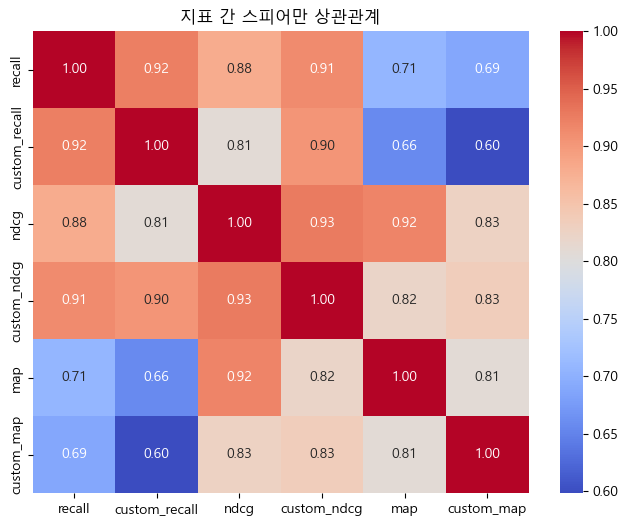

                 recall  custom_recall      ndcg  custom_ndcg       map  \
recall         1.000000       0.924272  0.879447     0.912158  0.707334   
custom_recall  0.924272       1.000000  0.806979     0.903709  0.656582   
ndcg           0.879447       0.806979  1.000000     0.927258  0.919288   
custom_ndcg    0.912158       0.903709  0.927258     1.000000  0.821573   
map            0.707334       0.656582  0.919288     0.821573  1.000000   
custom_map     0.687831       0.598166  0.827146     0.833700  0.807519   

               custom_map  
recall           0.687831  
custom_recall    0.598166  
ndcg             0.827146  
custom_ndcg      0.833700  
map              0.807519  
custom_map       1.000000  


In [27]:
metrics_cols = ['recall', 'custom_recall', 'ndcg', 'custom_ndcg', 'map', 'custom_map']
corr_matrix = filtered_result[metrics_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("지표 간 스피어만 상관관계")
plt.show()

print(corr_matrix)

In [28]:
df = filtered_result.copy()

# base 기준: recall > map > ndcg 기준 튜플 순위
df['base_rank'] = (
    df[['recall', 'map', 'ndcg']]
    .apply(tuple, axis=1)
    .rank(method='min', ascending=False)
)

# custom 기준: custom_recall > custom_map > custom_ndcg 기준 튜플 순위
df['custom_rank'] = (
    df[['custom_recall', 'custom_map', 'custom_ndcg']]
    .apply(tuple, axis=1)
    .rank(method='min', ascending=False)
)

# 상위 10개 인덱스 추출
top10_base = df.nsmallest(10, 'base_rank').index
top10_custom = df.nsmallest(10, 'custom_rank').index

# 공통 인덱스 계산
common_indices = set(top10_base).intersection(set(top10_custom))
common_count = len(common_indices)
ratio = common_count / 10 * 100

# 결과 출력
print(f"공통된 상위 10개 조합 수: {common_count}개")
print(f"비율: {ratio:.2f}%")

공통된 상위 10개 조합 수: 5개
비율: 50.00%


In [29]:
df = filtered_result.copy()
df = df.loc[df['k'] == 10]

# base 기준: recall > map > ndcg 기준 튜플 순위
df['base_rank'] = (
    df[['recall', 'map', 'ndcg']]
    .apply(tuple, axis=1)
    .rank(method='min', ascending=False)
)

# custom 기준: custom_recall > custom_map > custom_ndcg 기준 튜플 순위
df['custom_rank'] = (
    df[['custom_recall', 'custom_map', 'custom_ndcg']]
    .apply(tuple, axis=1)
    .rank(method='min', ascending=False)
)

# 상위 10개 인덱스 추출
top10_base = df.nsmallest(10, 'base_rank').index
top10_custom = df.nsmallest(10, 'custom_rank').index

# 공통 인덱스 계산
common_indices = set(top10_base).intersection(set(top10_custom))
common_count = len(common_indices)
ratio = common_count / 10 * 100

# 결과 출력
print(f"공통된 상위 10개 조합 수: {common_count}개")
print(f"비율: {ratio:.2f}%")

공통된 상위 10개 조합 수: 3개
비율: 30.00%


# 5. 기존 + Custom 데이터셋 최적화
### 평가 결과
* Custom_Dataset의 recall 최고지표: 0.604839
* 기존 Dataset의 recall 최고지표: 0.732667
* 병합(기존 + Custom) Dataset의 recall 최고지표: 0.657440
### 시사점
* 병합 데이터셋의 recall 지표(0.657440)가 목표 값인 0.8 대비 낮음
* 모듈형(Modular) RAG 아키텍쳐 기반의 성능 고도화 필요


In [31]:
merged_dataset = pd.read_csv('../data/rag/precompute_validset.csv')
merged_dataset['reference_contexts'] = merged_dataset['reference_contexts'].apply(lambda x : eval(x))

columns = merged_dataset.columns[4:]
for column in columns:
    merged_dataset[column] = merged_dataset[column].apply(lambda x : eval(x))

In [32]:
optimization_result_merged = optimization(configs, merged_dataset)

100%|██████████| 438/438 [00:02<00:00, 153.27it/s]


In [33]:
optimization_result_merged.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
367,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.581555,0.815476,0.527743,0.70,0.75,0.6875,0.833333,1.00,1.00
368,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.565635,0.806548,0.511261,0.70,0.75,0.6875,0.869048,1.00,0.75
400,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.576367,0.797619,0.516857,0.75,0.65,0.6875,0.797619,1.00,1.00
334,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.555797,0.797619,0.504753,0.65,0.70,0.6875,0.833333,1.00,1.00
401,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.540448,0.788690,0.472476,0.75,0.65,0.6875,0.833333,1.00,0.75
357,20,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.551977,0.779762,0.513550,0.80,0.65,0.6250,0.761905,0.95,1.00
335,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.546397,0.779762,0.497365,0.65,0.70,0.6875,0.833333,1.00,0.75
356,20,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.566831,0.770833,0.535305,0.80,0.65,0.6250,0.726190,0.95,1.00
235,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.565690,0.761905,0.540961,0.70,0.60,0.5625,0.797619,1.00,1.00
389,20,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.560667,0.761905,0.531432,0.80,0.60,0.6250,0.726190,0.95,1.00


In [38]:
optimization_result_merged.loc[optimization_result_merged['k'] == 10].sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
103,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.542634,0.690476,0.544111,0.65,0.50,0.5625,0.654762,0.95,1.00
136,10,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.532467,0.654762,0.579287,0.65,0.50,0.5625,0.583333,0.85,1.00
104,10,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.516407,0.654762,0.531215,0.65,0.50,0.5625,0.619048,0.90,0.75
59,10,20,threshold,bm25_kiwi,NaN,NaN,0.1,0.515200,0.654762,0.524773,0.70,0.45,0.4375,0.619048,0.90,1.00
125,10,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.524220,0.648810,0.559304,0.75,0.55,0.5000,0.488095,0.85,1.00
92,10,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.526300,0.645833,0.546988,0.70,0.55,0.5000,0.511905,0.85,1.00
70,10,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.507735,0.645833,0.515675,0.60,0.45,0.5000,0.619048,0.90,1.00
158,10,80,threshold,bm25_kiwi,NaN,NaN,0.1,0.514621,0.639881,0.561047,0.65,0.55,0.5000,0.523810,0.85,1.00
93,10,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.506086,0.636905,0.528511,0.70,0.50,0.5000,0.511905,0.85,1.00
60,10,20,threshold,bm25_kiwi,NaN,NaN,0.2,0.501295,0.636905,0.523930,0.70,0.40,0.4375,0.583333,0.90,1.00


In [37]:
optimization_result_merged.loc[optimization_result_merged['k'] == 15].sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
235,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.565690,0.761905,0.540961,0.70,0.60,0.5625,0.797619,1.00,1.00
202,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.545373,0.761905,0.505403,0.65,0.65,0.6250,0.833333,0.90,1.00
236,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.549105,0.752976,0.525289,0.70,0.65,0.5625,0.797619,1.00,0.75
268,15,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.560820,0.744048,0.548297,0.70,0.55,0.5625,0.761905,1.00,1.00
203,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.533294,0.735119,0.505827,0.65,0.65,0.5625,0.833333,0.90,0.75
269,15,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.524902,0.735119,0.499452,0.70,0.55,0.5625,0.797619,1.00,0.75
257,15,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.550204,0.726190,0.542968,0.75,0.60,0.5625,0.690476,0.90,1.00
224,15,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.553746,0.726190,0.533229,0.80,0.55,0.5625,0.654762,0.95,1.00
213,15,40,threshold,bm25,NaN,NaN,0.1,0.473714,0.723214,0.434227,0.75,0.60,0.5625,0.642857,0.95,1.00
225,15,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.533055,0.717262,0.519740,0.80,0.50,0.5625,0.654762,0.95,1.00


In [32]:
optimization_result_merged.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
221,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.599517,0.817529,0.557804,0.714286,0.833333,0.727273,0.838542,0.958333,1.0
254,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.607152,0.817529,0.547662,0.750000,0.833333,0.727273,0.807292,0.958333,1.0
222,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.587868,0.804598,0.551134,0.714286,0.833333,0.727273,0.854167,0.958333,0.5
255,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.578589,0.804598,0.521766,0.750000,0.833333,0.727273,0.822917,0.958333,0.5
188,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.566536,0.791667,0.528537,0.642857,0.666667,0.727273,0.838542,0.958333,1.0
89,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.586785,0.774425,0.564085,0.714286,0.666667,0.636364,0.776042,0.958333,1.0
189,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.558750,0.774425,0.522821,0.642857,0.666667,0.727273,0.838542,0.958333,0.5
90,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.576058,0.765805,0.556888,0.714286,0.666667,0.636364,0.807292,0.958333,0.5
56,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.558968,0.765805,0.529930,0.642857,0.666667,0.681818,0.807292,0.916667,1.0
211,20,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.570471,0.761494,0.570186,0.785714,0.666667,0.636364,0.729167,0.875000,1.0


In [36]:
optimization_result_merged.sort_values(by=['recall_multi_hop_abstract_query_synthesizer'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
222,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.587868,0.804598,0.551134,0.714286,0.833333,0.727273,0.854167,0.958333,0.5
221,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.599517,0.817529,0.557804,0.714286,0.833333,0.727273,0.838542,0.958333,1.0
188,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.566536,0.791667,0.528537,0.642857,0.666667,0.727273,0.838542,0.958333,1.0
189,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.558750,0.774425,0.522821,0.642857,0.666667,0.727273,0.838542,0.958333,0.5
255,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.578589,0.804598,0.521766,0.750000,0.833333,0.727273,0.822917,0.958333,0.5
56,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.558968,0.765805,0.529930,0.642857,0.666667,0.681818,0.807292,0.916667,1.0
57,15,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.548545,0.739943,0.532187,0.642857,0.666667,0.636364,0.807292,0.916667,0.5
254,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.607152,0.817529,0.547662,0.750000,0.833333,0.727273,0.807292,0.958333,1.0
90,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.576058,0.765805,0.556888,0.714286,0.666667,0.636364,0.807292,0.958333,0.5
123,15,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.563622,0.752874,0.556483,0.714286,0.666667,0.590909,0.791667,0.958333,0.5


In [37]:
optimization_result_merged.sort_values(by=['recall_exercise name, body part'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
254,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.607152,0.817529,0.547662,0.750000,0.833333,0.727273,0.807292,0.958333,1.0
221,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.599517,0.817529,0.557804,0.714286,0.833333,0.727273,0.838542,0.958333,1.0
188,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.566536,0.791667,0.528537,0.642857,0.666667,0.727273,0.838542,0.958333,1.0
222,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.587868,0.804598,0.551134,0.714286,0.833333,0.727273,0.854167,0.958333,0.5
189,20,20,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.558750,0.774425,0.522821,0.642857,0.666667,0.727273,0.838542,0.958333,0.5
255,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.578589,0.804598,0.521766,0.750000,0.833333,0.727273,0.822917,0.958333,0.5
177,20,20,threshold,bm25_kiwi,NaN,NaN,0.1,0.550046,0.748563,0.523238,0.750000,0.666667,0.681818,0.651042,0.916667,1.0
288,20,80,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.530275,0.735632,0.513810,0.714286,0.666667,0.681818,0.760417,0.833333,0.5
287,20,80,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.568137,0.752874,0.564193,0.714286,0.666667,0.681818,0.760417,0.833333,1.0
178,20,20,threshold,bm25_kiwi,NaN,NaN,0.2,0.544880,0.748563,0.517087,0.750000,0.666667,0.681818,0.651042,0.916667,1.0


In [38]:
optimization_result_merged.sort_values(by=['recall_exercise name'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
199,20,40,threshold,bm25,NaN,NaN,0.1,0.502268,0.745690,0.476303,0.750000,0.833333,0.545455,0.703125,0.916667,1.0
200,20,40,threshold,bm25,NaN,NaN,0.2,0.485118,0.702586,0.476298,0.714286,0.833333,0.545455,0.671875,0.875000,0.5
223,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.502490,0.688218,0.502057,0.535714,0.833333,0.590909,0.744792,0.875000,0.5
222,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.587868,0.804598,0.551134,0.714286,0.833333,0.727273,0.854167,0.958333,0.5
221,20,40,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.599517,0.817529,0.557804,0.714286,0.833333,0.727273,0.838542,0.958333,1.0
289,20,80,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.387826,0.670977,0.335033,0.535714,0.833333,0.590909,0.713542,0.833333,0.5
254,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.1,0.607152,0.817529,0.547662,0.750000,0.833333,0.727273,0.807292,0.958333,1.0
255,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.2,0.578589,0.804598,0.521766,0.750000,0.833333,0.727273,0.822917,0.958333,0.5
256,20,60,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.430581,0.670977,0.396944,0.535714,0.833333,0.590909,0.713542,0.833333,0.5
291,20,80,threshold,bm25_kiwi_pos,NaN,NaN,0.5,0.516616,0.688218,0.515991,0.535714,0.666667,0.636364,0.744792,0.875000,0.5


In [39]:
optimization_result_merged.sort_values(by=['recall_body part'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,recall_body part,recall_exercise name,"recall_exercise name, body part",recall_multi_hop_abstract_query_synthesizer,recall_multi_hop_specific_query_synthesizer,recall_single_hop_specifc_query_synthesizer
276,20,80,threshold,bm25_kiwi,NaN,NaN,0.1,0.568502,0.755747,0.559635,0.821429,0.666667,0.636364,0.739583,0.791667,1.0
244,20,60,threshold,bm25_kiwi,NaN,NaN,0.2,0.560987,0.761494,0.558617,0.785714,0.666667,0.636364,0.729167,0.875000,1.0
211,20,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.570471,0.761494,0.570186,0.785714,0.666667,0.636364,0.729167,0.875000,1.0
79,15,40,threshold,bm25_kiwi,NaN,NaN,0.2,0.556223,0.714080,0.572603,0.785714,0.500000,0.590909,0.619792,0.875000,1.0
277,20,80,threshold,bm25_kiwi,NaN,NaN,0.2,0.531121,0.747126,0.516846,0.785714,0.666667,0.636364,0.739583,0.791667,1.0
210,20,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.577640,0.757184,0.574857,0.785714,0.666667,0.636364,0.713542,0.875000,1.0
78,15,40,threshold,bm25_kiwi,NaN,NaN,0.1,0.565006,0.714080,0.577163,0.785714,0.500000,0.590909,0.619792,0.875000,1.0
243,20,60,threshold,bm25_kiwi,NaN,NaN,0.1,0.581696,0.757184,0.579692,0.785714,0.666667,0.636364,0.713542,0.875000,1.0
133,15,80,threshold,bm25,NaN,NaN,0.1,0.537177,0.676724,0.568920,0.750000,0.500000,0.545455,0.640625,0.750000,1.0
199,20,40,threshold,bm25,NaN,NaN,0.1,0.502268,0.745690,0.476303,0.750000,0.833333,0.545455,0.703125,0.916667,1.0
